## EDA



Import packages



In [1]:
import os
os.chdir("utils")

0 - 3c7df45a-b35e-40e6-82a6-8e9bc300663a

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import itertools as it

from abc import ABC, abstractmethod

from implementations import reg_logistic_regression
from helpers import sigmoid, create_csv_submission
from cross_validation import accuracy, f1_score
from costs import reg_logistic_error

:results:
  # Out[132]:
  :end:

Setup notebook settings



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

:results:
  # Out[77]:
  :end:

Read the training data



In [1]:
train = pd.read_csv("../data/train.csv")

:results:
  # Out[133]:
  :end:

In [1]:
X = train.replace(to_replace=-999, value=np.nan)

:results:
  # Out[79]:
  :end:

Replace the missing values by np.nan, and try list-wise deletion



In [1]:
cc = X.dropna()

:results:
  # Out[80]:
  :end:

We can also replace by the median of each corresponding column



In [1]:
X_imputed = X.fillna(value=X.median(), axis=0)

:results:
  # Out[81]:
  :end:

We are ultimately left with a sample of 68 thousand rows, which should be an adequate sample size for prediction.
  We also want to investigate the balance of the outcome. First, subset and coerce the label vector to numeric



In [1]:
y = np.where(np.asarray(cc.loc[:, 'Prediction']) == 's', 1, 0)
y

:results:
  # Out[82]:
  : array([1, 0, 1, ..., 1, 1, 0])
  :end:

Plot the outcome variable



:results:
  # Out[83]:
  : <BarContainer object of 2 artists>
  
  :end:

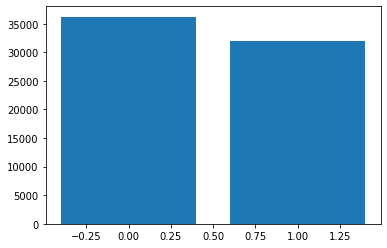

In [1]:
unique, counts = np.unique(y, return_counts=True)
plt.bar(unique, counts)

We have approximately 30 thousand labels that are classified as 1, and we see that the outcome is balanced among 1s 
  ans 0s. Hence, we are able to evaluate the model on a balanced outcome.

Now we create the feature set. Drop the Prediction and the id columns to create the feature matrix



In [1]:
c = ['Id', 'Prediction']
X = cc.drop(columns=c)

:results:
  # Out[84]:
  :end:

Standardize the feature set for prediction



In [1]:
X_standardized = (X - X.mean(axis=0)) / X.std(axis=0)

:results:
  # Out[85]:
  :end:

Augment the dataset with 1s, for the intercept of the model.



In [1]:
X_model = pd.concat([
    pd.DataFrame(
        np.ones((X_standardized.shape[0], 1)), 
        columns=['beta0'], 
        index=X_standardized.index
    ),
    X_standardized
], axis=1)
X_model.iloc[:5, :5]

:results:
  # Out[86]:
  #+BEGIN_EXAMPLE
    beta0  DER_mass_MMC  DER_mass_transverse_met_lep  DER_mass_vis  DER_pt_h
    0     1.0      0.257669                     0.532831      0.474607 -1.093446
    5     1.0     -0.544384                    -0.706345     -0.475040  0.064383
    6     1.0      0.426949                    -0.208398      0.719029 -0.069451
    11    1.0     -0.132872                    -0.812491     -0.068375 -1.056286
    23    1.0      0.307232                    -1.123057      0.812305  0.820829
  #+END_EXAMPLE
  :end:

To conduct the same data-preprocessing on the test set, we prepare a function for these operations



In [1]:
def missing_data_handling(raw_sample, method="cc", imp_percentage=None):
    """
    Handle missing data for the raw sample

    Parameters
    ----------
    raw_sample: Numpy array
        Sample to be handled.
    method: String
        Missing data handler. Must be one of 'cc' (for complete case)
        or 'si' (for simple, median imputation).
    imp_percentage: Float
        If method is 'si' and imp_percentage is specified, then only
        the features with proportions of missing data corresponding to
        imp_percentage will be imputed, the rest are removed. 
        If None (as default), all columns with missing data are handled
        using imputation.

    Returns
    -------
    raw_sample: Numpy array
        Sample with missing data handled.
    """
    assert method in ['cc', 'si'], "Parameter method must be one of 'cc', 'si'"
    sample = raw_sample.replace(to_replace=-999, value=np.nan)
    
    if method == 'cc':
        sample = sample.dropna()
    elif method == 'si':
        sample = sample.fillna(value=sample.median(), axis=0)
        
    return sample 

def conduct_data_preparation(raw_sample, missing_method="cc", 
                             include_outcome=True):
    """Missing data handling and data subsetting."""
    ## Drop nas
    sample = missing_data_handling(
        raw_sample,
        method=missing_method
    )
    ## Subset outcome 
    y = None
    if include_outcome:
        y = np.where(np.asarray(sample.loc[:, 'Prediction']) == 's', 1, 0)
    c = ['Id', 'Prediction']
    X = sample.drop(columns=c)

    return X, y


def prepare_features(X):
    """Missing data handling and augmentation."""
    ## Standardize sample
    X_standardized = (X - X.mean(axis=0)) / X.std(axis=0)
    ## Make prediction data
    X_model = pd.concat([
        pd.DataFrame(
            np.ones((X_standardized.shape[0], 1)), 
            columns=['beta0'], 
            index=X_standardized.index
        ),
        X_standardized
    ], axis=1)

    return X_model

:results:
  # Out[134]:
  :end:

Prepare the data with missing imputation



In [1]:
X, y = conduct_data_preparation(train, missing_method='si')

:results:
  # Out[136]:
  :end:

### Exploring the distributions of the variables



:results:
   # Out[91]:
   
   :end:

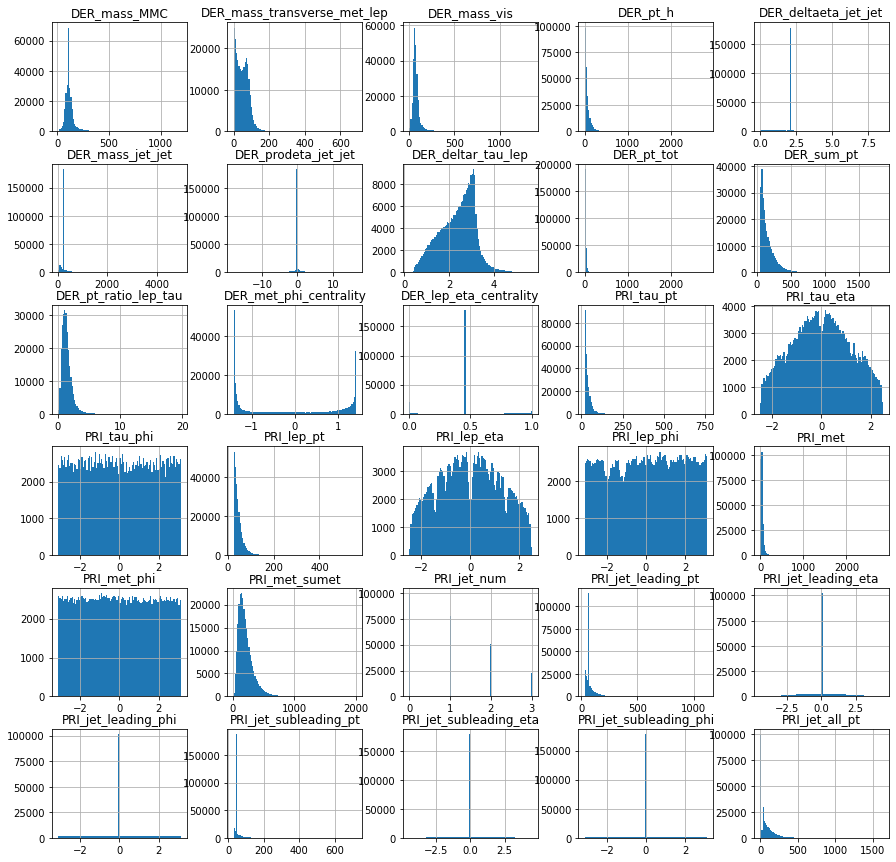

In [1]:
f = X.hist(figsize=(15, 15), bins = 100)

:RESULTS:
   # Out[99]:
   : <AxesSubplot:>
   
   :END:

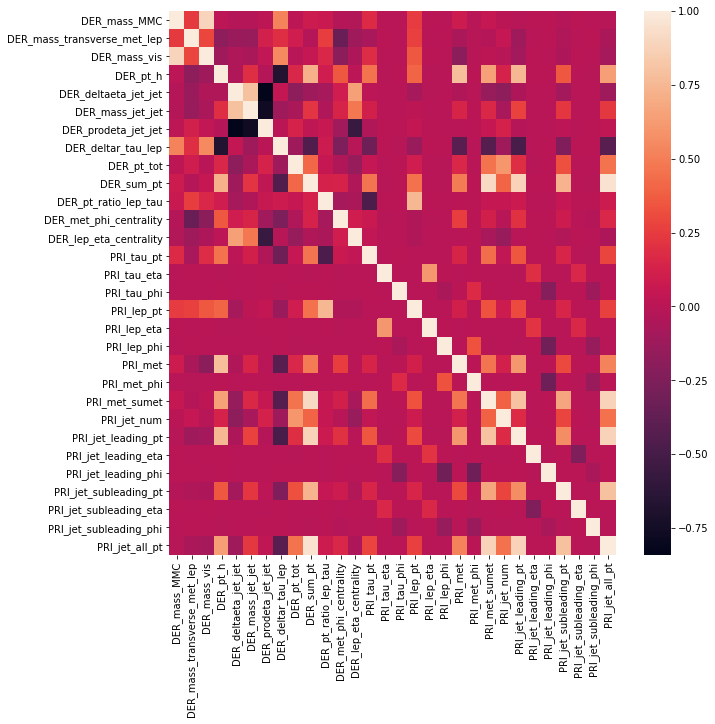

In [1]:
corr = X.corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    corr, 
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    ax=ax
)

## Training



Define a function similar to that in implementations, but constructed to work with dataframes



In [1]:
def split_data(x, y, ratio, shuffle=True, seed=1):
    """Split data into train and test set."""

    split = int(x.shape[0]*ratio)
    
    if shuffle:
        np.random.seed(seed)
        train_idx = np.random.permutation(np.arange(x.shape[0]))[:split]
        test_idx = np.random.permutation(np.arange(x.shape[0]))[split:]


        x_train = x.iloc[train_idx]
        y_train = y[train_idx]
        x_test = x.iloc[test_idx]
        y_test = y[test_idx]

    else:
        x_train = x.iloc[:split, :]
        y_train = y[:split]
        x_test = x.iloc[split:, :]
        y_test = y[split:]
    
    return x_train, x_test, y_train, y_test

:results:
  # Out[137]:
  :end:

Now, we don't want to conduct the data preparation on the full sample, as that would 
  cause information leakage, and biased oos performance. Hence we want to first split the training data



In [1]:
X_train, X_test, y_train, y_test =  split_data(X, y, 0.9)

:results:
  # Out[138]:
  :end:

and then prepare the features



In [1]:
X_train = prepare_features(X_train)
X_test = prepare_features(X_test)

:results:
  # Out[139]:
  :end:

Let's try to fit a regularized logistic regression model



In [1]:
w, loss = reg_logistic_regression(
    y=y_train.reshape(-1, 1),
    tx=np.asarray(X_train),
    lambda_=0.5,
    reg=1,
    initial_w=np.array([0.001 for x in X_train.columns])[np.newaxis].T,
    max_iters=50,
    gamma=0.05,
    batch_size=1
)

:results:
  # Out[157]:
  :end:

In [1]:
preds = np.rint(sigmoid(X_train @ w))
accuracy(y_train.reshape(-1, 1), preds)

:results:
  # Out[158]:
  : 0.6179955555555556
  :end:

Considering that all our models are similar in construction, and have similar method attached to them, let's define
  base classes for classifiers that enforce certain methods and a subclass for the specific classifier.



In [1]:
class Classifier(ABC):
    """Metaclass for classifier classes."""

    def __init__(self):
        pass

    @abstractmethod
    def fit(self, y, tx):
        raise NotImplementedError

    @abstractmethod
    def predict(self, w, tx):
        raise NotImplementedError

    @abstractmethod
    def compute_loss(self, y, tx, w):
        raise NotImplementedError
    

class RegularizedLogisticRegression(Classifier):
    """Implementation of regularized logistic regression."""

    def __init__(self, gamma, lambda_, reg):
        self.gamma = gamma
        self.lambda_ = lambda_
        self.reg = reg

    def fit(self, y, tx):
        return self.__reg_logistic_regression(y, tx)

    def predict(self, w, oos):
        return np.rint(sigmoid(oos @ w))

    def __reg_logistic_regression(self, y, tx):

        return reg_logistic_regression(
            y=y,
            tx=tx,
            lambda_=self.lambda_,
            reg=self.reg,
            initial_w=np.zeros((tx.shape[1], 1)),
            max_iters=100,
            gamma=self.gamma,
            batch_size=1  
        )

    def compute_loss(self, y, tx, w):
        
        return reg_logistic_error(
            y=y,
            tx=tx,
            w=w,
            lambda_=self.lambda_,
            reg=self.reg
        )

:results:
  # Out[96]:
  :end:

Define function for selecting the ks for cross-validation (from the lab)



In [1]:
def build_k_indices(y, k_fold, seed):
    """Build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

:results:
  # Out[159]:
  :end:

Define the cross-validation function, utilizing the build<sub>k</sub><sub>indices</sub>,



In [1]:
def cross_validation(y, x, k_indices, comb,
                     classifier=RegularizedLogisticRegression):
    """Return the loss of ridge regression."""
        
    test_losses = [0] * k_indices.shape[0]
    test_acc = [0] * k_indices.shape[0]
    for k in np.arange(k_indices.shape[0]):
        # Augment and set indices
        mask = np.arange(k_indices.shape[0]) == k
        tri = k_indices[~mask].ravel()
        tei = k_indices[mask].ravel()
        # Subset for trainin and test sets
        x_train = x[tri]
        x_test = x[tei]
        y_train = y[tri]
        y_test = y[tei]
        # Run prediction
        clf = classifier(**comb)
        w, loss = clf.fit(y_train, x_train)
        test_losses[k] = clf.compute_loss(
            y=y_test,
            tx=x_test,
            w=w
        )
        predictions = clf.predict(w, x_test)
        test_acc[k] = accuracy(y_test, predictions)

    return np.mean(test_losses), np.mean(test_acc)

:results:
  # Out[160]:
  :end:

Utilise a grid of hyperparameters, and a grid-search, for selecting the best hyperparameters for
  the model



In [1]:
def select_best_model(grid, y, X, k_fold, seed=1, verbose=False):
    """Evaluate candidate model over grid of hyperparameters.

    Parameters
    ----------
    grid: Dict
         The hyperparameter grid, the keys being the hyperparamaters
         and corresponding lists are the potential values.

    Returns
    -------
    loss_te : Real scalar
         The loss of the best performing candiate model, measures
         by its oos accuracy.
    best_params : Dictionary
         Dictionary of parameter-value combinations 
         for the best performing candidate model.
    """
    s = np.random.seed(seed)
    k_indices = build_k_indices(y, k_fold, s)
    k, v = zip(*grid.items())
    permutations = [dict(zip(k, values)) for values in it.product(*v)]

    ## Reshape data to correct format
    y = y.reshape(-1, 1)
    test_loss = [0] * len(permutations)
    test_acc = [0] * len(permutations)
    for k, comb in enumerate(permutations):
        np.random.seed(seed)
        teloss, teacc = cross_validation(
            y=y,
            x=X,
            k_indices=k_indices,
            comb=comb
        )
        if verbose:
            print("For Params: " + str(comb) +
                  "\n \t Mean Accuracy: " + str(teacc),
                  ", Mean Log. loss: " + str(teloss))

        test_loss[k] = teloss
        test_acc[k] = teacc
            
    acc = max(test_acc)
    loss = min(test_loss)
    best_params = permutations[np.argmax(test_acc)]

    return (acc, loss, best_params)

:results:
  # Out[161]:
  :end:

Test using simple grid. We do the hyperparameter tuning on training set, and the corresponding test sets
  in the cross validation are validation sets, rather than test sets. The test set is left for the
  last testing.



In [1]:
grid = {
    'gamma': [0.01, 0.1],
    'lambda_': [0.1, 0.2],
    'reg': [1, 2]
}
acc, loss, params = select_best_model(grid, y_train, np.asarray(X_train), 2, verbose=True)
"Test accuracy: {acc}, Test loss: {loss}, Best parameters: {params}".format(
    acc=acc,
    loss=loss,
    params=params
)

:results:
  # Out[162]:
  : "Test accuracy: 0.7261866666666666, Test loss: 0.5712946838377808, Best parameters: {'gamma': 0.1, 'lambda_': 0.1, 'reg': 2}"
  :end:

Train the model on the full training set using the "best" parameters found from the hyperparameter tuning.



In [1]:
clf = RegularizedLogisticRegression(
    **params
)
X, y = conduct_data_preparation(train, missing_method='si')
X_model = prepare_features(X)
w, loss = clf.fit(tx=np.array(X_model), y=y.reshape(-1, 1))

:results:
  # Out[163]:
  :end:

Check predictions on the sample



In [1]:
predictions = np.rint(sigmoid(X_model @ w))

:results:
  # Out[164]:
  :end:

In [1]:
acc = accuracy(
    y_targ=y,
    y_pred=np.array(predictions).ravel()
)
f1 = f1_score(
    y_targ=y,
    y_pred=np.array(predictions).ravel()
)
"Accuracy: {acc}, F1-score: {f1}".format(
    acc=acc, f1=f1
)

:results:
  # Out[166]:
  : 'Accuracy: 0.7259720000000001, F1-score: 0.5567123713141326'
  :end:

## Testing



In [1]:
test = pd.read_csv("../data/test.csv")

:results:
  # Out[167]:
  :end:

Create prediction data with the test set



In [1]:
X_test, _ = conduct_data_preparation(test, missing_method='si', include_outcome=False)
X_model_test = prepare_features(X_test)

:results:
  # Out[168]:
  :end:

In [1]:
predictions = np.rint(sigmoid(X_model_test @ w))
predictions[predictions == 0] = -1

:results:
  # Out[171]:
  #+BEGIN_EXAMPLE
    array([[-1.],
    [-1.],
    [-1.],
    ...,
    [-1.],
    [ 1.],
    [-1.]])
  #+END_EXAMPLE
  :end:

Generate submission



In [1]:
ids = test.Id
create_csv_submission(ids, predictions, "../predictions/submission_16102020.csv")

:results:
  # Out[175]:
  :end: